In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, optimizers, models
import numpy as np
from tensorflow.keras import regularizers

In [2]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
config = tf.compat.v1.ConfigProto() 
config.gpu_options.per_process_gpu_memory_fraction = 0.9 # GPU memory 
session = tf.compat.v1.Session(config=config)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:b1:00.0, compute capability: 7.0
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [101]:
class VGG16(tf.keras.Model):

    def __init__(self):
        super(VGG16, self).__init__()
        self.num_classes = 10
        self.layer1 = tf.keras.Sequential([layers.Conv2D(64, (3, 3), activation='relu',padding='same'),
                 layers.BatchNormalization(),
                 layers.Dropout(0.3)
            ])
        
        self.layer2 = tf.keras.Sequential([layers.Conv2D(64, (3, 3), activation='relu',padding='same'),
                 layers.BatchNormalization(),
                 layers.Dropout(0.3),
                 layers.MaxPooling2D(pool_size=(2, 2))
            ])
        
        self.layer3 = tf.keras.Sequential([layers.Conv2D(128, (3, 3), activation='relu',padding='same'),
                 layers.BatchNormalization(),
                 layers.Dropout(0.4)
            ])
        
        self.layer4 = tf.keras.Sequential([layers.Conv2D(128, (3, 3), activation='relu',padding='same'),
                 layers.BatchNormalization(),
                 layers.MaxPooling2D(pool_size=(2, 2))
                 
            ])
        
        self.layer5 = tf.keras.Sequential([layers.Conv2D(256, (3, 3), activation='relu',padding='same'),
                 layers.BatchNormalization(),
                 layers.Dropout(0.4)
            ])
        
        self.layer6 = tf.keras.Sequential([layers.Conv2D(256, (3, 3), activation='relu',padding='same'),
                 layers.BatchNormalization(),
                 layers.Dropout(0.4)
            ])
        self.layer7 = tf.keras.Sequential([layers.Conv2D(256, (3, 3), activation='relu',padding='same'),
                 layers.BatchNormalization(),
                 layers.MaxPooling2D(pool_size=(2, 2))
                 
            ])
        
        self.layer8 = tf.keras.Sequential([layers.Conv2D(512, (3, 3), activation='relu',padding='same'),
                 layers.BatchNormalization(),
                 layers.Dropout(0.4)
            ])
        
        self.layer9 = tf.keras.Sequential([layers.Conv2D(512, (3, 3), activation='relu',padding='same'),
                 layers.BatchNormalization(),
                 layers.Dropout(0.4)
            ])
        
        self.layer10 = tf.keras.Sequential([layers.Conv2D(512, (3, 3), activation='relu',padding='same'),
                 layers.BatchNormalization(),
                 layers.MaxPooling2D(pool_size=(2, 2))
                 
            ])
        
        self.layer11 = tf.keras.Sequential([layers.Conv2D(512, (3, 3), activation='relu',padding='same'),
                 layers.BatchNormalization(),
                 layers.Dropout(0.4)
            ])
        
        self.layer12 = tf.keras.Sequential([layers.Conv2D(512, (3, 3), activation='relu',padding='same'),
                 layers.BatchNormalization(),
                 layers.Dropout(0.4)
            ])
        self.layer13 = tf.keras.Sequential([layers.Conv2D(512, (3, 3), activation='relu',padding='same'),
                 layers.BatchNormalization(),
                 layers.MaxPooling2D(pool_size=(2, 2)),
                 layers.Dropout(0.5)
            ])
        self.flatten = layers.Flatten()
        self.layer14 = tf.keras.Sequential([layers.Dense(512,activation='relu'),
                                            layers.BatchNormalization(),
                                            layers.Dropout(0.5)
                                           ])
        self.layer15 = tf.keras.Sequential([layers.Dense(64,activation='relu'),
                                            layers.BatchNormalization(),
                                            layers.Dropout(0.5)
                                           ])
        self.layer16 = layers.Dense(self.num_classes,activation='softmax')

        


    def call(self, x):
        layer1 = self.layer1(x)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)
        layer5 = self.layer5(layer4)
        layer6 = self.layer6(layer5)
        layer7 = self.layer7(layer6)
        layer8 = self.layer8(layer7)
        layer9 = self.layer9(layer8)
        layer10 = self.layer10(layer9)
        layer11 = self.layer11(layer10)
        layer12 = self.layer12(layer11)
        layer13 = self.layer13(layer12)
        flatten = self.flatten(layer13)
        layer14 = self.layer14(flatten)
        layer15 = self.layer15(layer14)
        layer16 = self.layer16(layer15)
                                           

        return [layer16,layer15,layer14,layer13,layer12,layer11,layer10,layer9,layer8,
                layer7,layer6,layer5,layer4,layer3,layer2,layer1]
    
    def calculate_gram_mat(self,x):
        x = tf.reshape(x,[x.shape[0],-1]) 
        dist = tf.norm(x[:,None]-x,axis=2)
        dist = dist/tf.math.reduce_max(dist)
        sigma = tf.reduce_mean(tf.sort(dist)[0][0:50])
        k = tf.exp(-dist**2/sigma**2)
        k = k/tf.linalg.trace(k)
        return k
    
    def reyi_entropy(self,x):
        alpha = 1.01
        k = self.calculate_gram_mat(x)
        eigv = tf.abs(tf.linalg.eigvalsh(k))
        eig_pow = eigv**alpha
        entropy = (1/(1-alpha))*np.math.log2(tf.reduce_sum(eig_pow))
        return entropy
    
    def joint_entropy(self,x,y):
        alpha = 1.01
        x = self.calculate_gram_mat(x)
        y = self.calculate_gram_mat(y)
        k = (x*y)/tf.linalg.trace((x*y))
        eigv = tf.abs(tf.linalg.eigvalsh(k))
        eig_pow = eigv**alpha
        entropy = (1/(1-alpha))*np.math.log2(tf.reduce_sum(eig_pow))
        return entropy
    
    def calculate_MI(self,x,y):
        return self.reyi_entropy(x)+self.reyi_entropy(y)-self.joint_entropy(x,y)
        
        


In [69]:
from scipy.spatial.distance import pdist,squareform
x =tf.reshape(output_layer[13],[output_layer[13].shape[0],-1])
#dist = tf.norm(x[:,None]-x,axis=2)
#dist = dist/tf.math.reduce_max(dist)
#sigma = tf.reduce_mean(tf.sort(dist)[0][0:10])
#k = tf.exp(-dist**2/sigma**2)
#k = k/tf.linalg.trace(k)

In [88]:
x_batch = x_train[0:128,]
y_batch = y_train[0:128,]
x_batch = tf.convert_to_tensor(value =x_batch,dtype=tf.float32)
y_batch = tf.convert_to_tensor(value =y_batch,dtype=tf.float32)
output_layer = model(x_batch)
output_layer.append(x_batch)
output_layer.append(y_batch)

In [126]:
output_layer[0]
#model.calculate_MI(output_layer[-2],output_layer[16])

<tf.Tensor: id=350569, shape=(128, 10), dtype=float32, numpy=
array([[0.09993532, 0.09983256, 0.10004701, ..., 0.10005648, 0.09991161,
        0.10012794],
       [0.0999016 , 0.09978057, 0.10006706, ..., 0.10005266, 0.09991504,
        0.1001463 ],
       [0.09992305, 0.09979167, 0.10007317, ..., 0.1000281 , 0.09986632,
        0.10015428],
       ...,
       [0.09990502, 0.09981117, 0.10006332, ..., 0.10007375, 0.0998693 ,
        0.10015185],
       [0.09994082, 0.09984569, 0.10005805, ..., 0.10005439, 0.09989827,
        0.1001249 ],
       [0.09993186, 0.09981057, 0.10005771, ..., 0.1000736 , 0.09989009,
        0.10015498]], dtype=float32)>

In [222]:
x = output_layer[10]
x = tf.reshape(x,[x.shape[0],-1]) 
dist = tf.norm(x[:,None]-x,axis=2)
dist = dist/tf.math.reduce_max(dist)
sigma = tf.reduce_mean(tf.sort(dist)[0][0:50])
#sigma = 1
k = tf.exp(-dist**2/sigma**2)
k = k/tf.linalg.trace(k)

In [223]:
sigma

<tf.Tensor: id=4221216, shape=(), dtype=float32, numpy=0.4070061>

In [183]:
#model.joint_entropy(output_layer[-1],output_layer[0])
output_layer[10]

<tf.Tensor: id=349828, shape=(128, 8, 8, 256), dtype=float32, numpy=
array([[[[0.00000000e+00, 5.99257601e-03, 3.00012268e-02, ...,
          3.13162711e-03, 0.00000000e+00, 9.98819526e-03],
         [0.00000000e+00, 0.00000000e+00, 3.45690399e-02, ...,
          6.50547585e-03, 7.47220032e-03, 1.04582887e-02],
         [0.00000000e+00, 0.00000000e+00, 3.30239646e-02, ...,
          0.00000000e+00, 3.45706881e-04, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 3.99915613e-02, ...,
          0.00000000e+00, 5.79379092e-04, 2.23383717e-02],
         [0.00000000e+00, 0.00000000e+00, 1.39883151e-02, ...,
          0.00000000e+00, 0.00000000e+00, 6.48447452e-03],
         [0.00000000e+00, 0.00000000e+00, 6.59759576e-03, ...,
          0.00000000e+00, 7.61434902e-04, 0.00000000e+00]],

        [[0.00000000e+00, 2.52808165e-02, 3.49018760e-02, ...,
          0.00000000e+00, 3.51314917e-02, 0.00000000e+00],
         [0.00000000e+00, 8.61974712e-03, 3.76212634e-02, ...

In [ ]:
MI_x=np.zeros(16)
MI_y=np.zeros(16)
for i in range(16):
    MI_x[i] = model.calculate_MI(output_layer[-2],output_layer[i])
    MI_y[i] = model.calculate_MI(output_layer[i],output_layer[-1])
MI_xy = np.vstack((MI_x,MI_y))
MI_xy = MI_xy.reshape([1,2,16])

In [ ]:
MI_sample = np.zeros([1,2,16])
MI_sample = np.vstack((MI_sample,MI_xy))
MI_sample.shape

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.flip(MI_x))
#plt.plot(np.flip(MI_y))
print(MI_y)

In [ ]:
i

In [ ]:
x_batch = x_train[0:256,]
output_layer1 = model(x_batch)[0]
#dis_matrix
dist = tf.norm(output_layer1[:,None]-output_layer1,axis=2)
dist = dist/tf.math.reduce_max(dist)

In [ ]:
#gram_matrix with the kernel
sigma = tf.reduce_mean(tf.sort(dist)[0][0:10])
k = tf.exp(-dist**2/sigma**2)
k = k/tf.linalg.trace(k)

In [ ]:
#entropy
alpha = 1.01
eigv = tf.abs(tf.linalg.eigh(k)[0])
eig_pow = eigv**alpha
entropy = (1/(1-alpha))*np.math.log2(tf.reduce_sum(eig_pow))

In [ ]:
entropy

In [102]:
model = VGG16()
#model.build((1,32, 32, 3))
#model.summary()

In [103]:
def normalize(X_train, X_test):

    # this function normalize inputs for zero mean and unit variance
    # it is used when training a model.
    # Input: training set and test set
    # Output: normalized training set and test set according to the trianing set statistics.
    X_train = X_train / 255.
    X_test = X_test / 255.

    mean = np.mean(X_train, axis=(0, 1, 2, 3))
    std = np.std(X_train, axis=(0, 1, 2, 3))
    print('mean:', mean, 'std:', std)
    X_train = (X_train - mean) / (std + 1e-7)
    X_test = (X_test - mean) / (std + 1e-7)
    return X_train, X_test



def prepare_cifar(x, y):

    x = tf.cast(x, tf.float32)
    y = tf.cast(y, tf.int32)
    return x, y

In [104]:
(x_train,y_train), (x_test, y_test) = datasets.cifar10.load_data()
x_train, x_test = normalize(x_train, x_test)

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
print('x_train_shape: ',x_train.shape) 
print('y_train_shape: ',y_train.shape)
print('x_test_shape: ',x_test.shape) 
print('y_test_shape: ',y_test.shape)

mean: 0.4733630004850874 std: 0.25156892506322026
x_train_shape:  (50000, 32, 32, 3)
y_train_shape:  (50000, 10)
x_test_shape:  (10000, 32, 32, 3)
y_test_shape:  (10000, 10)


In [105]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_loader = train_loader.map(prepare_cifar).shuffle(50000).batch(256)
test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_loader = test_loader.map(prepare_cifar).shuffle(10000).batch(256)
print('done.')

done.


In [ ]:
i=666
plt.imshow(x_train[i,])
model(x_train[i:i+128,])[0]
#print('predict: ',np.argmax(model(x_train[i:i+1,])[0]))
#print('ground truth: ', y_train[i])
#type(x_train[0:1,])

In [106]:
optimizer = tf.optimizers.Adam(learning_rate=1e-4)
loss_object = tf.keras.losses.CategoricalCrossentropy()
train_accuracy = tf.keras.metrics.CategoricalAccuracy()
test_accuracy = tf.keras.metrics.CategoricalAccuracy()
train_avg_loss = tf.keras.metrics.Mean('train_avg_loss', dtype=tf.float32)
test_avg_loss = tf.keras.metrics.Mean('test_avg_loss', dtype=tf.float32)

In [107]:
@tf.function
def train_step(x_train,y_train):
    with tf.GradientTape() as tape:
        y_train_pre = model(x_train,training=True)
        loss_train = loss_object(y_train,y_train_pre[0])
    grads = tape.gradient(loss_train, model.trainable_variables)
    grads = [ tf.clip_by_norm(g, 15) for g in grads]
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_avg_loss(loss_train)
    train_accuracy(y_train, y_train_pre[0])

@tf.function
def test_step(x_test,y_test):
    y_test_pre = model(x_test,training=False)
    loss_test =loss_object(y_test,y_test_pre[0])
    test_avg_loss(loss_test)
    test_accuracy(y_test, y_test_pre[0])

@tf.function
def calculate_MI(x_train,y_train):
    output = model(x_train,training=False)
    output.append(x_train)
    output.append(y_train)
    MI_x=np.zeros(16)
    MI_y=np.zeros(16)
    for i in range(16):
        MI_x[i] = model.calculate_MI(output_layer[-2],output_layer[i])
        MI_y[i] = model.calculate_MI(output_layer[i],output_layer[-1])
    MI_xy = np.vstack((MI_x,MI_y))
    return MI_xy
    

In [108]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []
MI_sample = np.zeros([1,2,16])
for epoch in range(500):
    
    train_avg_loss.reset_states()
    test_avg_loss.reset_states()
    train_accuracy.reset_states()
    test_accuracy.reset_states()
    
    for x_train_batch,y_train_batch in train_loader:
        train_step(x_train_batch,y_train_batch)
    train_loss.append(train_avg_loss.result())
    train_acc.append(train_accuracy.result())

    
    output = model(x_train_batch,training=False)
    output.append(x_train_batch)
    y_tr_batch = tf.cast(y_train_batch, tf.float32)
    output.append(y_tr_batch)
    
    MI_x=np.zeros(16)
    MI_y=np.zeros(16)
    for i in range(16):
        MI_x[i] = model.calculate_MI(output[-2],output[i])
        MI_y[i] = model.calculate_MI(output[i],output[-1])
    MI_xy = np.vstack((MI_x,MI_y))
    MI_xy = MI_xy.reshape([1,2,16])

    
    for x_test_batch,y_test_batch in test_loader:
        test_step(x_test_batch,y_test_batch)
    test_loss.append(test_avg_loss.result())
    test_acc.append(test_accuracy.result())
    
    print("Epoch: {}, train_loss: {:.5f},train_acc:{:.3%},test_loss: {:.5f},test_acc: {:.3%}"
          .format(epoch,train_avg_loss.result(),
                  train_accuracy.result(),
                  test_avg_loss.result(),
                 test_accuracy.result())) 
    
    MI_sample = np.vstack((MI_sample,MI_xy))

Epoch: 0, train_loss: 3.06416,train_acc:11.260%,test_loss: 2.56917,test_acc: 9.490%
Epoch: 1, train_loss: 2.53235,train_acc:15.314%,test_loss: 3.04992,test_acc: 11.210%
Epoch: 2, train_loss: 2.26782,train_acc:18.416%,test_loss: 2.75601,test_acc: 11.670%
Epoch: 3, train_loss: 2.13610,train_acc:21.226%,test_loss: 2.56713,test_acc: 15.150%
Epoch: 4, train_loss: 2.03234,train_acc:24.290%,test_loss: 2.24048,test_acc: 18.980%
Epoch: 5, train_loss: 1.93470,train_acc:27.172%,test_loss: 2.33156,test_acc: 22.650%
Epoch: 6, train_loss: 1.86103,train_acc:30.002%,test_loss: 2.40723,test_acc: 23.990%
Epoch: 7, train_loss: 1.78767,train_acc:33.018%,test_loss: 2.25724,test_acc: 26.090%
Epoch: 8, train_loss: 1.70947,train_acc:36.424%,test_loss: 3.72538,test_acc: 26.470%
Epoch: 9, train_loss: 1.64998,train_acc:38.968%,test_loss: 4.41907,test_acc: 27.270%
Epoch: 10, train_loss: 1.58531,train_acc:41.684%,test_loss: 2.20651,test_acc: 29.960%
Epoch: 11, train_loss: 1.52194,train_acc:44.620%,test_loss: 2.745

Epoch: 96, train_loss: 0.10010,train_acc:97.008%,test_loss: 0.79121,test_acc: 84.430%
Epoch: 97, train_loss: 0.09588,train_acc:97.124%,test_loss: 0.79411,test_acc: 84.210%
Epoch: 98, train_loss: 0.09454,train_acc:97.130%,test_loss: 0.84471,test_acc: 83.860%
Epoch: 99, train_loss: 0.09912,train_acc:97.062%,test_loss: 0.80681,test_acc: 83.940%
Epoch: 100, train_loss: 0.09052,train_acc:97.316%,test_loss: 0.82745,test_acc: 83.960%
Epoch: 101, train_loss: 0.08729,train_acc:97.444%,test_loss: 0.81490,test_acc: 84.320%
Epoch: 102, train_loss: 0.08845,train_acc:97.352%,test_loss: 0.79912,test_acc: 84.120%
Epoch: 103, train_loss: 0.08723,train_acc:97.426%,test_loss: 0.83031,test_acc: 83.980%
Epoch: 104, train_loss: 0.08868,train_acc:97.378%,test_loss: 0.78167,test_acc: 84.400%
Epoch: 105, train_loss: 0.08572,train_acc:97.386%,test_loss: 0.80511,test_acc: 84.250%
Epoch: 106, train_loss: 0.07957,train_acc:97.620%,test_loss: 0.78848,test_acc: 84.100%
Epoch: 107, train_loss: 0.08423,train_acc:97.50

Epoch: 191, train_loss: 0.04087,train_acc:98.826%,test_loss: 0.88746,test_acc: 85.530%
Epoch: 192, train_loss: 0.03727,train_acc:98.888%,test_loss: 0.82398,test_acc: 86.030%
Epoch: 193, train_loss: 0.03365,train_acc:98.980%,test_loss: 0.79712,test_acc: 86.330%
Epoch: 194, train_loss: 0.03503,train_acc:98.978%,test_loss: 0.85911,test_acc: 85.890%
Epoch: 195, train_loss: 0.03370,train_acc:98.962%,test_loss: 0.82572,test_acc: 85.970%
Epoch: 196, train_loss: 0.03397,train_acc:99.036%,test_loss: 0.87695,test_acc: 85.330%
Epoch: 197, train_loss: 0.03178,train_acc:99.116%,test_loss: 0.85067,test_acc: 85.520%
Epoch: 198, train_loss: 0.03682,train_acc:98.938%,test_loss: 0.88616,test_acc: 85.640%
Epoch: 199, train_loss: 0.03572,train_acc:98.966%,test_loss: 0.81228,test_acc: 85.760%
Epoch: 200, train_loss: 0.03624,train_acc:98.946%,test_loss: 0.81789,test_acc: 85.990%
Epoch: 201, train_loss: 0.03413,train_acc:98.938%,test_loss: 0.87501,test_acc: 85.400%
Epoch: 202, train_loss: 0.03060,train_acc:9

Epoch: 286, train_loss: 0.02038,train_acc:99.368%,test_loss: 0.81253,test_acc: 87.050%
Epoch: 287, train_loss: 0.01992,train_acc:99.444%,test_loss: 0.81581,test_acc: 86.860%
Epoch: 288, train_loss: 0.02189,train_acc:99.328%,test_loss: 0.80652,test_acc: 86.880%
Epoch: 289, train_loss: 0.02162,train_acc:99.352%,test_loss: 0.83475,test_acc: 86.420%
Epoch: 290, train_loss: 0.02044,train_acc:99.400%,test_loss: 0.85988,test_acc: 86.230%
Epoch: 291, train_loss: 0.02025,train_acc:99.386%,test_loss: 0.87819,test_acc: 86.360%
Epoch: 292, train_loss: 0.02110,train_acc:99.388%,test_loss: 0.85327,test_acc: 86.480%
Epoch: 293, train_loss: 0.02127,train_acc:99.400%,test_loss: 0.86608,test_acc: 86.580%
Epoch: 294, train_loss: 0.02181,train_acc:99.382%,test_loss: 0.82972,test_acc: 86.710%
Epoch: 295, train_loss: 0.02165,train_acc:99.380%,test_loss: 0.83086,test_acc: 86.560%
Epoch: 296, train_loss: 0.01926,train_acc:99.420%,test_loss: 0.83777,test_acc: 86.770%
Epoch: 297, train_loss: 0.02003,train_acc:9

Epoch: 381, train_loss: 0.01595,train_acc:99.534%,test_loss: 0.86272,test_acc: 87.100%
Epoch: 382, train_loss: 0.01718,train_acc:99.512%,test_loss: 0.83893,test_acc: 87.100%
Epoch: 383, train_loss: 0.01445,train_acc:99.582%,test_loss: 0.82378,test_acc: 87.050%
Epoch: 384, train_loss: 0.01507,train_acc:99.596%,test_loss: 0.83686,test_acc: 87.380%
Epoch: 385, train_loss: 0.01422,train_acc:99.552%,test_loss: 0.83973,test_acc: 87.160%
Epoch: 386, train_loss: 0.01372,train_acc:99.606%,test_loss: 0.82353,test_acc: 87.380%
Epoch: 387, train_loss: 0.01493,train_acc:99.552%,test_loss: 0.85212,test_acc: 86.910%
Epoch: 388, train_loss: 0.01632,train_acc:99.522%,test_loss: 0.87249,test_acc: 86.730%
Epoch: 389, train_loss: 0.01494,train_acc:99.596%,test_loss: 0.85814,test_acc: 86.890%
Epoch: 390, train_loss: 0.01525,train_acc:99.586%,test_loss: 0.89007,test_acc: 86.650%
Epoch: 391, train_loss: 0.01557,train_acc:99.556%,test_loss: 0.86572,test_acc: 86.900%
Epoch: 392, train_loss: 0.01594,train_acc:9

Epoch: 476, train_loss: 0.01196,train_acc:99.636%,test_loss: 0.87802,test_acc: 86.930%
Epoch: 477, train_loss: 0.01061,train_acc:99.636%,test_loss: 0.85462,test_acc: 87.230%
Epoch: 478, train_loss: 0.01241,train_acc:99.668%,test_loss: 0.89278,test_acc: 87.040%
Epoch: 479, train_loss: 0.01291,train_acc:99.646%,test_loss: 0.85172,test_acc: 87.300%
Epoch: 480, train_loss: 0.01422,train_acc:99.588%,test_loss: 0.85750,test_acc: 87.120%
Epoch: 481, train_loss: 0.01286,train_acc:99.644%,test_loss: 0.86737,test_acc: 87.190%
Epoch: 482, train_loss: 0.01051,train_acc:99.716%,test_loss: 0.85817,test_acc: 86.790%
Epoch: 483, train_loss: 0.01073,train_acc:99.704%,test_loss: 0.85364,test_acc: 87.290%
Epoch: 484, train_loss: 0.01094,train_acc:99.684%,test_loss: 0.87673,test_acc: 87.230%
Epoch: 485, train_loss: 0.01131,train_acc:99.686%,test_loss: 0.85618,test_acc: 87.190%
Epoch: 486, train_loss: 0.01066,train_acc:99.718%,test_loss: 0.86428,test_acc: 87.060%
Epoch: 487, train_loss: 0.01080,train_acc:9

In [225]:
MI_sample1 = MI_sample[1:]
MI_sample1.shape
np.save('MI.npy',MI_sample)

In [ ]:
np.save()

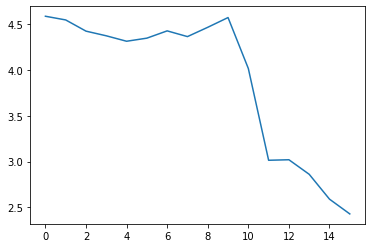

In [182]:
import matplotlib.pyplot as plt
MI_1 = np.flip(MI_sample[400,0,:])
plt.plot(MI_1)

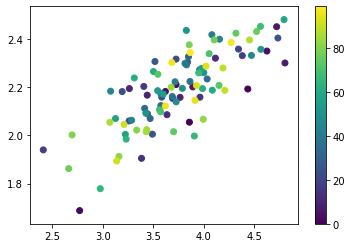

In [201]:
epoch = np.arange(0,500,1)
MI_layer1 = MI_sample1[:,:,12]
MI_layer1.shape
plt.scatter(MI_layer1[0:100,0],MI_layer1[0:100,1],c=np.arange(0,100,1))
plt.colorbar()

In [ ]:
output = model(x_train_batch,training=False)
output.append(x_train_batch)
output.append(y_train_batch)
MI_x=np.zeros(16)
MI_y=np.zeros(16)
for i in range(16):
    MI_x[i] = model.calculate_MI(output[-2],output[i])
    #MI_y[i] = model.calculate_MI(output[i],output[-1])
MI_xy = np.vstack((MI_x,MI_y))
MI_xy = MI_xy.reshape([1,2,16])

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.array(train_loss),label='train_dis_loss')
plt.plot(np.array(test_loss),label='test_gen_loss')
#plt.plot(np.array(test_dis))
#plt.plot(np.array(test_gen))
plt.legend()
plt.grid()
plt.xlabel("epoach")
plt.ylabel("loss")
plt.ylim([0,2])

plt.show()

In [20]:
model.save_weights('vgg16_180.h5')

In [ ]:
model.load_weights('vgg16_180.h5')